In [128]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [129]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [130]:
def prepare_data(ticker):
    stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    stock_news = pd.read_csv(f"../dataset/polygon_title_sentiment_3/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date

    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = 0.0
    stock_news['pos_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_score'] = 0.0
    stock_news['neg_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_mean'] = np.nan
    stock_news['pos_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_mean'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [sentiment_transform(['positive']), sentiment_transform(['negative'])], 
        'pos_score': 'mean', 'neg_score': 'mean', 'pos_mean': 'mean', 'neg_mean': 'mean'
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative', 
                           'pos_score', 'neg_score', 'pos_mean', 'neg_mean']
    return relation_gp

In [ ]:
relation_gp = prepare_data(ticker='META')
relation_gp_t = relation_gp[relation_gp['negative'] > 0]
len(relation_gp_t), len(relation_gp)

/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_2169/2186838793.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


(416, 502)

In [132]:
def test_relevance(cols):
    X, y = relation_gp_t[cols], relation_gp_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [133]:
test_relevance(['negative'])

(24.939341290830008, 0.024983085744476385, array([-7.24406622]))

In [134]:
test_relevance(['neg_score'])

(24.825393507580813, 0.029437935402062965, array([8.86158804]))

In [135]:
test_relevance(['neg_mean'])

(25.46568227492009, 0.004405502873736089, array([2.18426079]))

In [136]:
test_relevance(['negative', 'neg_mean'])

(24.88126679843218, 0.027253539150377204, array([-6.97860954,  1.57960365]))

In [137]:
test_relevance(['positive', 'negative'])

(24.846588736784685, 0.02860929655654154, array([ 2.15885424, -6.77997291]))

In [ ]:
test_relevance(['pos_score', 'neg_score'])

(24.778795021638057,
 0.03125972818492173,
 array([ 2.27352143, -6.46795877,  1.70996284]))

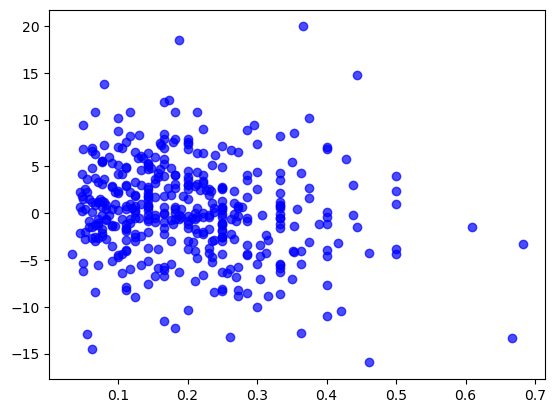

In [139]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp_t['negative'], relation_gp_t['delta'], color='blue', alpha=0.7)

In [140]:
def preprocess(relation_gp, feat_cols):
    seq_length = 10
    std_scaler = StandardScaler()
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(relation_gp[feat_cols])

    X = []
    y = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = np.array(X)
    y = np.array(y)

    split_index = int(len(X) * 0.95)
    X, X_test = X[:split_index], X[split_index:]
    y, y_test = y[:split_index], y[split_index:]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=67)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) 
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 

    return X_train, X_val, X_test, y_train, y_val, y_test

In [141]:
class SimpleLSTM(nn.Module):
    def __init__(self, feat_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.fc1 = nn.Linear(feat_size[0], feat_size[1])
        self.lstm = nn.LSTM(feat_size[1], feat_size[2], num_layers=layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(feat_size[2], feat_size[3])
    
    def forward(self, x):
        inp = self.fc1(x)
        lstm_out, (hn, cn) = self.lstm(inp)
        out = self.fc2(hn[-1])
        return out

In [142]:
feat_cols = ['neg_score', 'close']
model = SimpleLSTM(feat_size=[len(feat_cols), 16, 64, 1], layers=2, dropout=0.5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(relation_gp, feat_cols)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([443, 10, 2]),
 torch.Size([24, 10, 2]),
 torch.Size([25, 10, 2]),
 torch.Size([443, 1]),
 torch.Size([24, 1]),
 torch.Size([25, 1]))

In [143]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

Epoch 1, Train Loss: 0.9443, Test Loss: 1.2302
Epoch 2, Train Loss: 0.9124, Test Loss: 1.1618
Epoch 3, Train Loss: 0.8803, Test Loss: 1.0895
Epoch 4, Train Loss: 0.8454, Test Loss: 1.0119
Epoch 5, Train Loss: 0.8057, Test Loss: 0.9276
Epoch 6, Train Loss: 0.7592, Test Loss: 0.8356
Epoch 7, Train Loss: 0.7137, Test Loss: 0.7352
Epoch 8, Train Loss: 0.6570, Test Loss: 0.6263
Epoch 9, Train Loss: 0.5890, Test Loss: 0.5099
Epoch 10, Train Loss: 0.5203, Test Loss: 0.3886
Epoch 11, Train Loss: 0.4394, Test Loss: 0.2675
Epoch 12, Train Loss: 0.3581, Test Loss: 0.1552
Epoch 13, Train Loss: 0.2745, Test Loss: 0.0651
Epoch 14, Train Loss: 0.1902, Test Loss: 0.0142
Epoch 15, Train Loss: 0.1278, Test Loss: 0.0157
Epoch 16, Train Loss: 0.0792, Test Loss: 0.0619
Epoch 17, Train Loss: 0.0603, Test Loss: 0.1149
Epoch 18, Train Loss: 0.0649, Test Loss: 0.1392
Epoch 19, Train Loss: 0.0848, Test Loss: 0.1294
Epoch 20, Train Loss: 0.1050, Test Loss: 0.1009
Epoch 21, Train Loss: 0.1244, Test Loss: 0.0693
E

In [144]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 0.0051
Std: 0.0946
Error Range: 0.7529
